In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# This method is responsible for importing the data from the csv file
def import_csv(filename):
    import csv
    data = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            data = data + [row]
    csvfile.close()
    darray = np.array(data)
    return darray[1:, 0], darray[1:, 1] 

In [3]:
x, y = import_csv('project02_task2.csv')

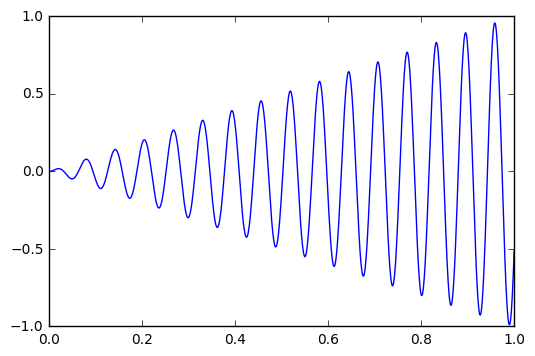

In [4]:
plt.plot(x, y)
plt.show()

# Now we have the data and we can start wit the LSTM RNN

In [ ]:
def lstm_model(time_steps, rnn_layers, dense_layers=None):
    """
    Creates a deep model based on:
        * stacked lstm cells
        * an optional dense layers
    :param time_steps: the number of time steps the model will be looking at.
    :param rnn_layers: list of int or dict
                         * list of int: the steps used to instantiate the `BasicLSTMCell` cell
                         * list of dict: [{steps: int, keep_prob: int}, ...]
    :param dense_layers: list of nodes for each layer
    :return: the model definition
    """
    
    def lstm_cells(layers):
        if isinstance(layers[0], dict):
            return [tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.BasicLSTMCell(layer['steps'],
                                                                               state_is_tuple=True),
                                                  layer['keep_prob'])
                    if layer.get('keep_prob') else tf.nn.rnn_cell.BasicLSTMCell(layer['steps'],
                                                                                state_is_tuple=True)
                    for layer in layers]
        return [tf.nn.rnn_cell.BasicLSTMCell(steps, state_is_tuple=True) for steps in layers]
    
    def dnn_layers(input_layers, layers):
        if layers and isinstance(layers, dict):
            return learn.ops.dnn(input_layers,
                                 layers['layers'],
                                 activation=layers.get('activation'),
                                 dropout=layers.get('dropout'))
        elif layers:
            return learn.ops.dnn(input_layers, layers)
        else:
            return input_layers
    
    def _lstm_model(X, y):
        stacked_lstm = tf.nn.rnn_cell.MultiRNNCell(lstm_cells(rnn_layers), state_is_tuple=True)
        x_ = learn.ops.split_squeeze(1, time_steps, X)
        output, layers = tf.nn.rnn(stacked_lstm, x_, dtype=dtypes.float32)
        output = dnn_layers(output[-1], dense_layers)
        return learn.models.linear_regression(output, y)
    
    return _lstm_model

Epoch 1/6
13s - loss: 0.0506
Epoch 2/6
12s - loss: 0.0064
Epoch 3/6
12s - loss: 0.0031
Epoch 4/6
12s - loss: 6.9385e-04
Epoch 5/6
12s - loss: 2.5479e-04
Epoch 6/6
12s - loss: 2.5206e-04
Train Score: 0.03 RMSE
Test Score: 0.08 RMSE


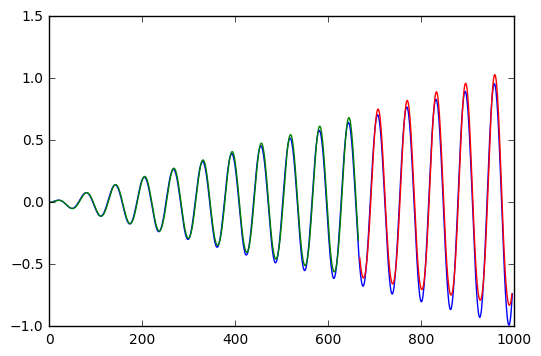

In [9]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = pandas.read_csv('project02_task2.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=6, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()